# Heart Disease UCI – 2.6 Hyperparameter Tuning

## Title & Overview
This notebook performs systematic hyperparameter tuning on multiple supervised classifiers for the Heart Disease UCI dataset (selected features). The workflow:

1. Load and split data (stratified).
2. Train baseline models with default settings.
3. Define tuning strategy (coarse RandomizedSearchCV then refined GridSearchCV).
4. Execute searches with multi-metric scoring (refit ROC AUC).
5. Evaluate tuned vs baseline performance (Accuracy, Precision, Recall, F1, ROC AUC).
6. Visualize search results (top configs, heatmaps), ROC curves, and confusion matrices.
7. Persist best model and reproducibility artifacts (JSON + CV results CSV).
8. (Optional) Evaluate best model on PCA-reduced dataset if available.

**Deliverables**
- Baseline vs tuned comparison table (+ metric deltas).
- Random search summary and refined grid results.
- ROC curves (baseline vs tuned), confusion matrices for tuned models.
- Heatmaps of key parameter interactions.
- Exported best model (`../models/best_model.pkl`) & JSON report (`../results/best_model_report.json`).
- Concatenated CV results CSV (`../results/tuning_cv_results.csv`).

---

## Imports & Global Config

In [75]:
import warnings, time, json
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform, loguniform

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
                                 confusion_matrix, classification_report, precision_recall_curve, average_precision_score)
from sklearn.calibration import calibration_curve
from sklearn.base import clone
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

# Optional XGBoost
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 110
RANDOM_STATE = 42
FAST_MODE = True  # Set False for deeper searches
np.random.seed(RANDOM_STATE)
print('Config ready. XGBoost available:' , XGBOOST_AVAILABLE)

Config ready. XGBoost available: True


## Load Data & Train/Test Split

In [76]:
DATA_PATH = Path('../data/selected_features.csv')
if not DATA_PATH.exists(): raise FileNotFoundError(f'Missing data file: {DATA_PATH}')
df = pd.read_csv(DATA_PATH)

# --- Feature Engineering Additions ---
if 'chol' in df.columns and 'age' in df.columns and 'chol_per_age' not in df.columns:
    df['chol_per_age'] = df['chol'] / (df['age'] + 1)
if {'thalach','trestbps'}.issubset(df.columns) and 'heart_rate_reserve' not in df.columns:
    df['heart_rate_reserve'] = df['thalach'] - df['trestbps']
# Interaction terms
if {'age','chol'}.issubset(df.columns) and 'age_chol' not in df.columns:
    df['age_chol'] = df['age'] * df['chol']
if {'trestbps','oldpeak'}.issubset(df.columns) and 'trestbps_oldpeak' not in df.columns:
    df['trestbps_oldpeak'] = df['trestbps'] * df['oldpeak']

X = df.drop(columns=['num'])
y = df['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print('Train shape:', X_train.shape, ' Test shape:', X_test.shape)
print('Train positive ratio:', y_train.mean().round(3), ' Test positive ratio:', y_test.mean().round(3))
display(X_train.head())

Train shape: (736, 19)  Test shape: (184, 19)
Train positive ratio: 0.553  Test positive ratio: 0.554


,cp_non-anginal,fbs_True,exang_True,chol,chol_per_age,ca,trestbps,slope_flat,sex_Male,heart_rate_reserve,oldpeak,thalch,thal_normal,slope_upsloping,cp_atypical angina,thal_reversable defect,age,age_chol,trestbps_oldpeak
640,True,False,True,0.0,0.000000,1,160.0,True,True,-38.0,0.0,122.0,False,False,False,True,53,0.0,0.0
743,True,False,False,0.0,0.000000,1,130.0,False,True,8.0,0.5,140.0,False,True,False,True,74,0.0,65.0
890,False,False,True,243.0,4.584905,1,124.0,True,True,-2.0,2.0,122.0,False,False,False,True,53,12879.0,248.0
270,False,False,True,207.0,3.393442,1,140.0,False,True,-2.0,1.9,138.0,False,True,False,True,61,12627.0,266.0
654,True,False,False,0.0,0.000000,1,155.0,True,True,-56.0,0.0,99.0,True,False,False,False,56,0.0,0.0


## Baseline Models (Default Hyperparameters)
We build baseline pipelines (scaling where appropriate) and record performance metrics on the test set.

In [77]:
def build_baseline_models():
    models = {}
    # Logistic Regression (scaled)
    models['LogisticRegression'] = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=500, solver='liblinear', random_state=RANDOM_STATE))])
    # Decision Tree
    models['DecisionTree'] = DecisionTreeClassifier(random_state=RANDOM_STATE)
    # Random Forest
    models['RandomForest'] = RandomForestClassifier(random_state=RANDOM_STATE)
    # SVC (scaled)
    models['SVC'] = Pipeline([('scaler', StandardScaler()), ('clf', SVC(probability=True, random_state=RANDOM_STATE))])
    return models

def evaluate_model(name, model, Xtr, Xte, ytr, yte):
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(Xte)[:,1]
    else:
        y_proba = None
    metrics = {
        'model': name,
        'accuracy': accuracy_score(yte, y_pred),
        'precision': precision_score(yte, y_pred),
        'recall': recall_score(yte, y_pred),
        'f1': f1_score(yte, y_pred),
        'roc_auc': roc_auc_score(yte, y_proba) if y_proba is not None else np.nan
    }
    return metrics, y_proba

baseline_models = build_baseline_models()
baseline_rows = []
baseline_probas = {}
for name, m in baseline_models.items():
    row, proba = evaluate_model(name, m, X_train, X_test, y_train, y_test)
    baseline_rows.append(row)
    baseline_probas[name] = proba
baseline_results = pd.DataFrame(baseline_rows).set_index('model')
print('Baseline Performance:')
display(baseline_results.round(4))

Baseline Performance:


,accuracy,precision,recall,f1,roc_auc
model,,,,,
LogisticRegression,0.8370,0.8333,0.8824,0.8571,0.9081
DecisionTree,0.7772,0.7905,0.8137,0.8019,0.7727
RandomForest,0.8370,0.8462,0.8627,0.8544,0.9030
SVC,0.8587,0.8393,0.9216,0.8785,0.9044


## Hyperparameter Tuning Strategy (Plan)
We adopt a two-phase approach:
1. **RandomizedSearchCV**: Broad exploration (n_iter configurable) using wide prior distributions.
2. **GridSearchCV**: Focused refinement around the best region from the random search.

Settings:
- CV: StratifiedKFold(5, shuffle=True, random_state=42)
- Multi-metric scoring: accuracy, precision, recall, f1, roc_auc (refit='roc_auc')
- Parallelization: n_jobs=-1
- Reproducibility: random_state=42 throughout.

## RandomizedSearchCV (Coarse Search)
We define pipelines & distributions per model and run randomized searches.

In [78]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'roc_auc': 'roc_auc'}
N_ITER = 40  # adjust for speed if needed

# Define search spaces
rs_specs = {}  # name -> (estimator, param_distributions)
rs_specs['LogisticRegression'] = (Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE))]), {
    'clf__C': loguniform(1e-3, 1e2),
    'clf__penalty': ['l1', 'l2'],
    'clf__class_weight': [None, 'balanced']
})
rs_specs['DecisionTree'] = (DecisionTreeClassifier(random_state=RANDOM_STATE), {
    'max_depth': randint(2, 30),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy', 'log_loss']
})
rs_specs['RandomForest'] = (RandomForestClassifier(random_state=RANDOM_STATE), {
    'n_estimators': randint(100, 600),
    'max_depth': randint(3, 40),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced']
})
rs_specs['SVC'] = (Pipeline([('scaler', StandardScaler()), ('clf', SVC(probability=True, random_state=RANDOM_STATE))]), {
    'clf__C': loguniform(1e-3, 1e2),
    'clf__kernel': ['rbf', 'linear', 'poly'],
    'clf__gamma': loguniform(1e-4, 1e0),
    'clf__degree': randint(2, 5)  # used only for poly kernel (ignored otherwise)
})

random_search_results = []  # store dicts
best_random_models = {}
for name, (estimator, dist) in rs_specs.items():
    print(f'[Random Search] {name}')
    start = time.time()
    rs = RandomizedSearchCV(estimator=estimator, param_distributions=dist, n_iter=N_ITER, cv=cv, scoring=scoring, refit='roc_auc', n_jobs=-1, random_state=RANDOM_STATE, verbose=0)
    rs.fit(X_train, y_train)
    elapsed = time.time() - start
    print(f'Best ROC AUC: {rs.best_score_:.4f}  | Time: {elapsed:.1f}s')
    print('Best Params:', rs.best_params_)
    cv_df = pd.DataFrame(rs.cv_results_)
    cv_df['model'] = name
    random_search_results.append(cv_df)
    best_random_models[name] = rs

[Random Search] LogisticRegression
Best ROC AUC: 0.8824  | Time: 559.0s
Best Params: {'clf__C': np.float64(0.03618723330959624), 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}
Best ROC AUC: 0.8824  | Time: 559.0s
Best Params: {'clf__C': np.float64(0.03618723330959624), 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}
[Random Search] DecisionTree
Best ROC AUC: 0.8215  | Time: 14.7s
Best Params: {'criterion': 'log_loss', 'max_depth': 21, 'min_samples_leaf': 15, 'min_samples_split': 12}
[Random Search] RandomForest
[Random Search] DecisionTree
Best ROC AUC: 0.8215  | Time: 14.7s
Best Params: {'criterion': 'log_loss', 'max_depth': 21, 'min_samples_leaf': 15, 'min_samples_split': 12}
[Random Search] RandomForest
Best ROC AUC: 0.8821  | Time: 219.5s
Best Params: {'class_weight': None, 'max_depth': 31, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 3, 'n_estimators': 269}
Best ROC AUC: 0.8821  | Time: 219.5s
Best Params: {'class_weight': None, 'max_depth': 3

### Top Random Search Configurations (Per Model)
Display top configurations ranked by mean_test_roc_auc.

In [79]:
top_random_summary = {}
for rs_df in random_search_results:
    name = rs_df['model'].iloc[0]
    cols = [c for c in rs_df.columns if c.startswith('param_')] + ['mean_test_roc_auc','mean_test_f1','mean_fit_time']
    top = rs_df.sort_values('mean_test_roc_auc', ascending=False)[cols].head(10)
    top_random_summary[name] = top
    print(f"\nModel: {name} (Top 10 by ROC AUC)")
    display(top)
# Concatenate all for export later
all_random_cv = pd.concat(random_search_results, ignore_index=True)


Model: LogisticRegression (Top 10 by ROC AUC)


,param_clf__C,param_clf__class_weight,param_clf__penalty,mean_test_roc_auc,mean_test_f1,mean_fit_time
23,0.036187,balanced,l2,0.882415,0.827313,0.013657
22,0.019674,balanced,l2,0.882336,0.827843,0.015852
18,0.033348,None,l2,0.882043,0.840282,0.013474
39,0.061991,None,l2,0.881970,0.838581,0.014676
10,1.146211,balanced,l2,0.881636,0.828834,0.014159
12,0.190700,None,l2,0.881489,0.839168,0.013771
26,49.830438,balanced,l2,0.881446,0.829706,0.021417
24,0.541441,balanced,l1,0.881410,0.832568,0.019640
13,0.009963,None,l2,0.881395,0.834898,0.010150
17,67.322489,balanced,l2,0.881370,0.831206,0.018139



Model: DecisionTree (Top 10 by ROC AUC)


,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_roc_auc,mean_test_f1,mean_fit_time
0,log_loss,21,15,12,0.821504,0.806830,0.012530
36,log_loss,28,19,3,0.820298,0.804100,0.011791
23,log_loss,12,19,18,0.820298,0.804100,0.010300
7,log_loss,16,19,13,0.820298,0.804100,0.014562
5,entropy,23,12,18,0.817745,0.790976,0.026130
16,entropy,19,12,3,0.817745,0.790976,0.013036
13,log_loss,15,17,5,0.817529,0.791316,0.010231
33,log_loss,8,17,5,0.817529,0.791316,0.017611
26,gini,9,12,3,0.816697,0.808736,0.012004
21,gini,16,13,2,0.816497,0.800007,0.016455



Model: RandomForest (Top 10 by ROC AUC)


,param_class_weight,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_roc_auc,mean_test_f1,mean_fit_time
25,None,31,sqrt,7,3,269,0.882138,0.834071,1.115110
26,None,8,log2,7,8,289,0.882018,0.834036,2.388611
17,None,37,sqrt,5,11,330,0.881833,0.839283,1.297588
13,balanced,23,sqrt,2,16,152,0.881328,0.836877,0.614113
31,None,39,sqrt,8,18,286,0.881157,0.833157,1.066862
30,None,14,log2,7,3,486,0.881015,0.833700,1.875068
24,None,34,log2,5,8,336,0.880859,0.834945,1.443790
36,balanced,8,log2,1,10,223,0.880141,0.833616,0.895370
14,balanced,28,sqrt,9,16,400,0.880006,0.824336,1.623901
7,None,20,sqrt,2,10,445,0.879957,0.840581,1.799263



Model: SVC (Top 10 by ROC AUC)


,param_clf__C,param_clf__degree,param_clf__gamma,param_clf__kernel,mean_test_roc_auc,mean_test_f1,mean_fit_time
15,0.094570,3,0.081113,poly,0.885107,0.845645,0.091514
4,0.011526,2,0.029507,linear,0.883172,0.844368,0.066622
35,26.085628,3,0.000308,rbf,0.882836,0.843850,0.116734
26,0.082155,4,0.071282,rbf,0.882006,0.840321,0.257795
33,2.978000,3,0.031435,linear,0.880177,0.834736,0.344431
34,1.468990,3,0.006701,linear,0.879731,0.837259,0.181822
30,0.238150,2,0.010821,linear,0.879580,0.831505,0.096439
22,7.183759,2,0.507228,linear,0.879465,0.838909,0.746063
13,0.133592,3,0.015376,linear,0.879427,0.831787,0.076357
12,35.204810,3,0.044678,linear,0.878752,0.841058,3.315315


## GridSearchCV (Refined Search)
We build narrow grids around best random parameters.

In [80]:
def neighborhood(val, factors=[0.5, 1, 2], to_int=False, floor=1):
    vals = []
    for f in factors:
        new_v = val * f
        if to_int:
            new_v = int(round(new_v))
            if new_v < floor:
                new_v = floor
        vals.append(new_v)
    return sorted(set(vals))

grid_search_results = []
best_grid_models = {}
for name, rs in best_random_models.items():
    best_params = rs.best_params_
    print(f'[Grid Search] {name}')
    if name == 'LogisticRegression':
        C_best = best_params['clf__C']
        grid = { 'clf__C': neighborhood(C_best, [0.33, 0.67, 1, 1.5, 2.0]), 'clf__penalty': [best_params['clf__penalty']], 'clf__class_weight': [best_params.get('clf__class_weight')] }
        base_est = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE))])
    elif name == 'DecisionTree':
        grid = {
            'max_depth': neighborhood(best_params['max_depth'], [0.5, 1, 1.5], to_int=True, floor=2),
            'min_samples_split': neighborhood(best_params['min_samples_split'], [0.5,1,1.5], to_int=True, floor=2),
            'min_samples_leaf': neighborhood(best_params['min_samples_leaf'], [0.5,1,1.5], to_int=True, floor=1),
            'criterion': [best_params['criterion']]
        }
        base_est = DecisionTreeClassifier(random_state=RANDOM_STATE)
    elif name == 'RandomForest':
        grid = {
            'n_estimators': neighborhood(best_params['n_estimators'], [0.5, 1, 1.5], to_int=True, floor=50),
            'max_depth': neighborhood(best_params['max_depth'], [0.5,1,1.5], to_int=True, floor=2),
            'min_samples_split': neighborhood(best_params['min_samples_split'], [0.5,1,1.5], to_int=True, floor=2),
            'min_samples_leaf': neighborhood(best_params['min_samples_leaf'], [0.5,1,1.5], to_int=True, floor=1),
            'max_features': [best_params['max_features']],
            'class_weight': [best_params.get('class_weight')]
        }
        base_est = RandomForestClassifier(random_state=RANDOM_STATE)
    elif name == 'SVC':
        Cb = best_params['clf__C']
        gb = best_params['clf__gamma']
        grid = {
            'clf__C': neighborhood(Cb, [0.33, 0.67, 1, 1.5, 2], to_int=False),
            'clf__gamma': neighborhood(gb, [0.5,1,2], to_int=False),
            'clf__kernel': [best_params['clf__kernel']],
        }
        if best_params['clf__kernel'] == 'poly':
            grid['clf__degree'] = neighborhood(best_params['clf__degree'], [1,1.5], to_int=True, floor=2)
        base_est = Pipeline([('scaler', StandardScaler()), ('clf', SVC(probability=True, random_state=RANDOM_STATE))])
    else:
        continue
    gs = GridSearchCV(base_est, param_grid=grid, cv=cv, scoring=scoring, refit='roc_auc', n_jobs=-1, verbose=0)
    t0 = time.time(); gs.fit(X_train, y_train); t1 = time.time()
    print(f'Best ROC AUC: {gs.best_score_:.4f} | Time: {t1 - t0:.1f}s')
    print('Best Params (grid):', gs.best_params_)
    gdf = pd.DataFrame(gs.cv_results_); gdf['model'] = name; grid_search_results.append(gdf)
    best_grid_models[name] = gs

[Grid Search] LogisticRegression
Best ROC AUC: 0.8824 | Time: 0.8s
Best Params (grid): {'clf__C': np.float64(0.03618723330959624), 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}
Best ROC AUC: 0.8824 | Time: 0.8s
Best Params (grid): {'clf__C': np.float64(0.03618723330959624), 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}
[Grid Search] DecisionTree
[Grid Search] DecisionTree
Best ROC AUC: 0.8244 | Time: 4.6s
Best Params (grid): {'criterion': 'log_loss', 'max_depth': 10, 'min_samples_leaf': 22, 'min_samples_split': 6}
[Grid Search] RandomForest
Best ROC AUC: 0.8244 | Time: 4.6s
Best Params (grid): {'criterion': 'log_loss', 'max_depth': 10, 'min_samples_leaf': 22, 'min_samples_split': 6}
[Grid Search] RandomForest
Best ROC AUC: 0.8821 | Time: 248.6s
Best Params (grid): {'class_weight': None, 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 269}
[Grid Search] SVC
Best ROC AUC: 0.8821 | Time: 248.6s
Best Params (grid): {

## Evaluation: Tuned vs Baseline
Evaluate both baseline and tuned models on the test set and compute metric deltas (tuned - baseline).

In [81]:
def evaluate_final(model, Xte, yte):
    y_pred = model.predict(Xte)
    y_proba = model.predict_proba(Xte)[:,1] if hasattr(model, 'predict_proba') else None
    return {
        'accuracy': accuracy_score(yte, y_pred),
        'precision': precision_score(yte, y_pred),
        'recall': recall_score(yte, y_pred),
        'f1': f1_score(yte, y_pred),
        'roc_auc': roc_auc_score(yte, y_proba) if y_proba is not None else np.nan,
        'y_pred': y_pred, 'y_proba': y_proba
    }

comparison_rows = []
model_eval_details = {}  # name -> dict of baseline/tuned metrics & curves
for name in baseline_models.keys():
    base_obj = baseline_models[name]
    tuned_obj = best_grid_models.get(name, best_random_models[name])  # fallback to random if grid missing
    tuned_est = tuned_obj.best_estimator_
    base_metrics = evaluate_final(base_obj, X_test, y_test)
    tuned_metrics = evaluate_final(tuned_est, X_test, y_test)
    model_eval_details[name] = {'baseline': base_metrics, 'tuned': tuned_metrics}
    for setting, metrics in [('baseline', base_metrics), ('tuned', tuned_metrics)]:
        comparison_rows.append({ 'model': name, 'setting': setting, **{k:v for k,v in metrics.items() if k not in ['y_pred','y_proba']} })
tuning_results = pd.DataFrame(comparison_rows).set_index(['model','setting'])
# Add delta columns (wide format pivot)
pivot_metrics = tuning_results.reset_index().pivot(index='model', columns='setting')
delta_df = pd.DataFrame({})
for metric in ['accuracy','precision','recall','f1','roc_auc']:
    delta_df[metric + '_delta'] = pivot_metrics[(metric,'tuned')] - pivot_metrics[(metric,'baseline')]
display(tuning_results.round(4))
print('Metric Deltas (tuned - baseline):')
display(delta_df.round(4))

accuracy  precision  recall      f1  roc_auc
model              setting                                               
LogisticRegression baseline    0.8370     0.8333  0.8824  0.8571   0.9081
                   tuned       0.8424     0.8614  0.8529  0.8571   0.9108
DecisionTree       baseline    0.7772     0.7905  0.8137  0.8019   0.7727
                   tuned       0.7826     0.7500  0.9118  0.8230   0.8510
RandomForest       baseline    0.8370     0.8462  0.8627  0.8544   0.9030
                   tuned       0.8315     0.8318  0.8725  0.8517   0.9039
SVC                baseline    0.8587     0.8393  0.9216  0.8785   0.9044
                   tuned       0.8370     0.8000  0.9412  0.8649   0.9096

Metric Deltas (tuned - baseline):


,accuracy_delta,precision_delta,recall_delta,f1_delta,roc_auc_delta
model,,,,,
DecisionTree,0.0054,-0.0405,0.0980,0.0211,0.0783
LogisticRegression,0.0054,0.0281,-0.0294,0.0000,0.0027
RandomForest,-0.0054,-0.0144,0.0098,-0.0027,0.0009
SVC,-0.0217,-0.0393,0.0196,-0.0136,0.0053


### Tuned vs Baseline Summary
Models with the largest positive ROC AUC / F1 deltas show the greatest benefit from tuning. Minimal or negative changes suggest defaults were near-optimal or potential overfitting.

### Enhancement Addendum: Advanced Feature Engineering, Imbalance Handling, Ensembles & Advanced Evaluation
This section augments (does not replace) earlier results with:
- Engineered & interaction features (added earlier in data cell).
- Robust scaling + polynomial expansion (LogReg & SVM) for non-linear decision boundaries.
- Multiple imbalance strategies: SMOTE, SMOTEENN, class weight.
- Refined, narrower hyperparameter ranges (domain-informed) including optional XGBoost.
- Soft Voting + Stacking ensembles.
- Precision-Recall curves, calibration plots, and threshold optimization (max F1).
- Consolidated comparison of baseline, tuned, ensembles, and threshold-tuned metrics.
All original cells remain unchanged; new outputs are appended for interpretability.

In [82]:
# Refined hyperparameter search with imbalance strategies
refined_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring_refined = {'roc_auc':'roc_auc','f1':'f1','precision':'precision','recall':'recall','accuracy':'accuracy'}

imbalance_strategies = {
    'none': None,
    'smote': SMOTE(random_state=RANDOM_STATE),
    'smoteenn': SMOTEENN(random_state=RANDOM_STATE)
}

polynomial = PolynomialFeatures(degree=2, include_bias=False)

refined_specs = {}
# Logistic Regression pipeline (RobustScaler + Poly + optional sampler)
refined_specs['logreg'] = {
    'base': LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
    'params': {
        'clf__C': loguniform(0.01, 10),
        'clf__penalty': ['l1','l2'],
        'clf__class_weight': [None, 'balanced']
    },
    'poly': True
}
# Decision Tree
refined_specs['dt'] = {
    'base': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'params': {
        'clf__max_depth': list(range(4,11)),
        'clf__min_samples_split': list(range(2,21)),
        'clf__min_samples_leaf': list(range(1,11))
    },
    'poly': False
}
# Random Forest
refined_specs['rf'] = {
    'base': RandomForestClassifier(random_state=RANDOM_STATE),
    'params': {
        'clf__n_estimators': list(range(300, 601, 50)),
        'clf__max_depth': list(range(5,16)),
        'clf__max_features': ['sqrt', 0.3, 0.5],
        'clf__class_weight': [None,'balanced']
    },
    'poly': False
}
# SVC
refined_specs['svc'] = {
    'base': SVC(probability=True, random_state=RANDOM_STATE),
    'params': {
        'clf__C': [0.1,1,10,50],
        'clf__gamma': [0.001,0.01,0.1,'scale'],
        'clf__kernel': ['rbf']
    },
    'poly': True
}
# Optional XGBoost
if 'XGBOOST_AVAILABLE' in globals() and XGBOOST_AVAILABLE:
    refined_specs['xgb'] = {
        'base': XGBClassifier(random_state=RANDOM_STATE, objective='binary:logistic', eval_metric='logloss', n_jobs=-1, use_label_encoder=False),
        'params': {
            'clf__n_estimators': list(range(300, 601, 100)),
            'clf__learning_rate': [0.01,0.05,0.1],
            'clf__max_depth': list(range(3,11)),
            'clf__subsample': [0.7,0.9,1.0],
            'clf__colsample_bytree': [0.7,0.9,1.0]
        },
        'poly': False
    }

refined_search_results = {}
for strat_name, sampler in imbalance_strategies.items():
    refined_search_results[strat_name] = {}
    print(f"\n=== Strategy: {strat_name} ===")
    for key, spec in refined_specs.items():
        steps = [('scaler', RobustScaler())]
        if spec['poly']:
            steps.append(('poly', polynomial))
        if sampler is not None:
            steps.append(('sampler', sampler))
        steps.append(('clf', spec['base']))
        pipe_cls = ImbPipeline if sampler is not None else Pipeline
        pipe = pipe_cls(steps)
        # Adjust solver if penalty includes l1 & 'liblinear' fine; if saga desired, could add.
        rs_iter = 15 if FAST_MODE else 40
        rs = RandomizedSearchCV(pipe, param_distributions=spec['params'], n_iter=rs_iter, scoring=scoring_refined, refit='roc_auc', cv=refined_cv, n_jobs=-1, random_state=RANDOM_STATE, verbose=0)
        t0 = time.time(); rs.fit(X_train, y_train); t1 = time.time()
        print(f"{key} best ROC AUC: {rs.best_score_:.4f} ({t1-t0:.1f}s) strat={strat_name}")
        refined_search_results[strat_name][key] = rs

# Pick best per model across strategies
best_refined_models = {}
for model_key in refined_specs.keys():
    best_obj = None; best_score = -np.inf; best_strategy = None
    for strat_name, model_dict in refined_search_results.items():
        rs_obj = model_dict.get(model_key)
        if rs_obj and rs_obj.best_score_ > best_score:
            best_score = rs_obj.best_score_
            best_obj = rs_obj
            best_strategy = strat_name
    if best_obj:
        best_refined_models[model_key] = (best_obj, best_strategy)
        print(f"Selected strategy for {model_key}: {best_strategy} ROC AUC={best_score:.4f}")


=== Strategy: none ===
logreg best ROC AUC: 0.8881 (9.5s) strat=none
logreg best ROC AUC: 0.8881 (9.5s) strat=none
dt best ROC AUC: 0.8155 (3.8s) strat=none
dt best ROC AUC: 0.8155 (3.8s) strat=none
rf best ROC AUC: 0.8782 (111.4s) strat=none
rf best ROC AUC: 0.8782 (111.4s) strat=none
svc best ROC AUC: 0.8894 (20.5s) strat=none
svc best ROC AUC: 0.8894 (20.5s) strat=none
xgb best ROC AUC: 0.8795 (56.4s) strat=none

=== Strategy: smote ===
xgb best ROC AUC: 0.8795 (56.4s) strat=none

=== Strategy: smote ===
logreg best ROC AUC: 0.8869 (66.2s) strat=smote
logreg best ROC AUC: 0.8869 (66.2s) strat=smote
dt best ROC AUC: 0.8263 (3.0s) strat=smote
dt best ROC AUC: 0.8263 (3.0s) strat=smote
rf best ROC AUC: 0.8784 (105.9s) strat=smote
rf best ROC AUC: 0.8784 (105.9s) strat=smote
svc best ROC AUC: 0.8891 (23.4s) strat=smote
svc best ROC AUC: 0.8891 (23.4s) strat=smote
xgb best ROC AUC: 0.8791 (37.2s) strat=smote

=== Strategy: smoteenn ===
xgb best ROC AUC: 0.8791 (37.2s) strat=smote

=== S

Consolidated Performance Table:


,group,model,strategy,accuracy,precision,recall,f1,roc_auc
0,baseline,DecisionTree,default,0.7772,0.7905,0.8137,0.8019,0.7727
1,tuned,DecisionTree,grid/random,0.7826,0.7500,0.9118,0.8230,0.8510
2,baseline,LogisticRegression,default,0.8370,0.8333,0.8824,0.8571,0.9081
3,tuned,LogisticRegression,grid/random,0.8424,0.8614,0.8529,0.8571,0.9108
4,baseline,RandomForest,default,0.8370,0.8462,0.8627,0.8544,0.9030
5,tuned,RandomForest,grid/random,0.8315,0.8318,0.8725,0.8517,0.9039
6,baseline,SVC,default,0.8587,0.8393,0.9216,0.8785,0.9044
7,tuned,SVC,grid/random,0.8370,0.8000,0.9412,0.8649,0.9096
8,refined,dt,smote,0.8152,0.7931,0.9020,0.8440,0.8760
9,threshold_tuned,dt,thr_opt,0.8152,0.7931,0.9020,0.8440,0.8760


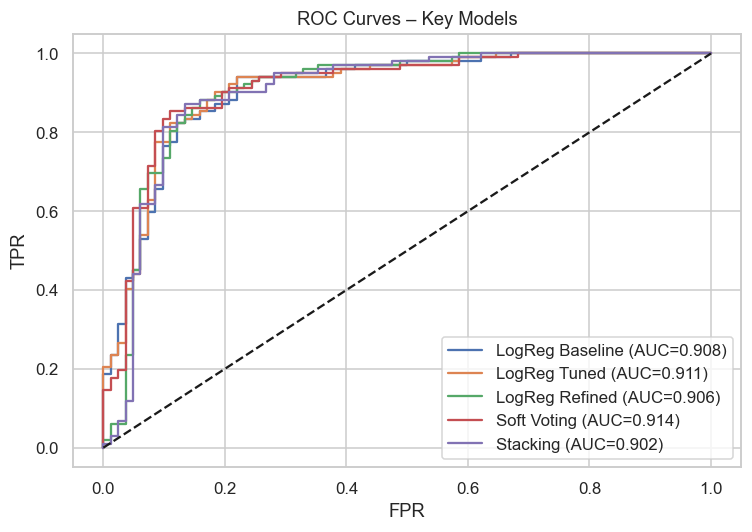

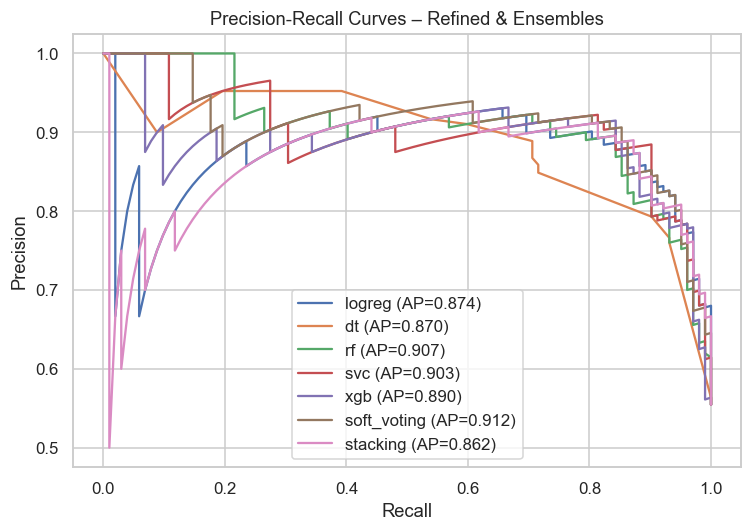

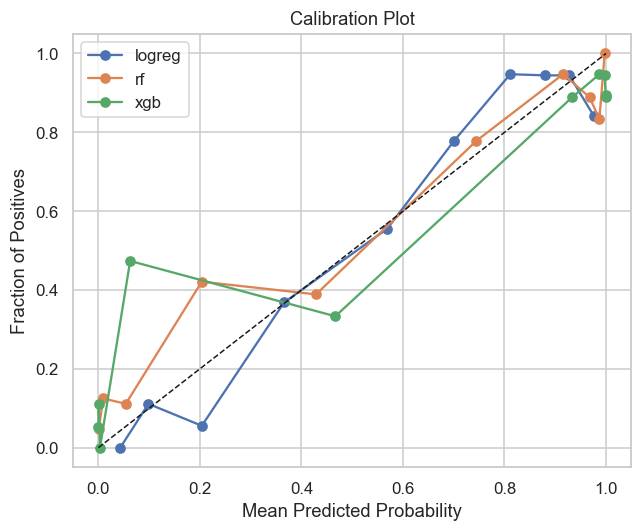

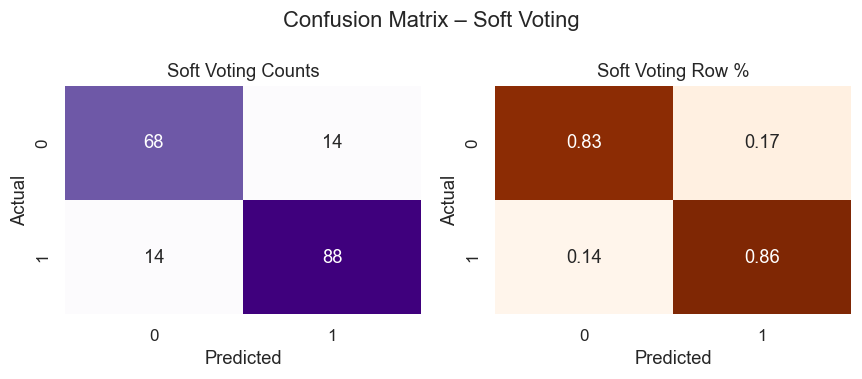

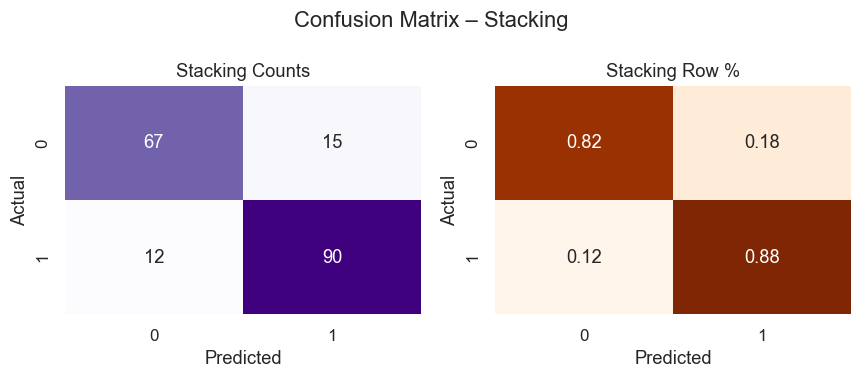


FINAL SUMMARY:
Top model overall: soft_voting (threshold_tuned) ROC AUC=0.9136 F1=0.8788
Recall emphasis: In medical diagnosis, higher recall reduces missed positive cases (false negatives). Threshold tuning offers an avenue to trade some precision for recall.


In [83]:
# Ensure StackingClassifier available if cell re-run standalone
try:
    StackingClassifier  # type: ignore
except NameError:
    from sklearn.ensemble import StackingClassifier
try:
    precision_recall_curve  # type: ignore
except NameError:
    from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
try:
    calibration_curve  # type: ignore
except NameError:
    from sklearn.calibration import calibration_curve

# Evaluate refined best models on test set
advanced_metrics_rows = []
model_probability_cache = {}
for key, (rs_obj, strat) in best_refined_models.items():
    est = rs_obj.best_estimator_
    y_pred = est.predict(X_test)
    y_proba = est.predict_proba(X_test)[:,1] if hasattr(est,'predict_proba') else None
    row = {
        'group':'refined',
        'model': key,
        'strategy': strat,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    }
    advanced_metrics_rows.append(row)
    model_probability_cache[key] = y_proba

# Build ensembles (soft voting of available refined models)
ensemble_estimators = []
for key,(rs_obj, strat) in best_refined_models.items():
    ensemble_estimators.append((key, rs_obj.best_estimator_))

soft_voting = VotingClassifier(estimators=ensemble_estimators, voting='soft')
soft_voting.fit(X_train, y_train)
y_pred_v = soft_voting.predict(X_test)
y_proba_v = soft_voting.predict_proba(X_test)[:,1]
advanced_metrics_rows.append({
    'group':'ensemble', 'model':'soft_voting', 'strategy':'mixed',
    'accuracy': accuracy_score(y_test, y_pred_v),
    'precision': precision_score(y_test, y_pred_v),
    'recall': recall_score(y_test, y_pred_v),
    'f1': f1_score(y_test, y_pred_v),
    'roc_auc': roc_auc_score(y_test, y_proba_v)
})

# Stacking ensemble (final estimator logistic regression)
final_estimator = LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE)
stacking = StackingClassifier(
    estimators=ensemble_estimators,
    final_estimator=final_estimator,
    stack_method='predict_proba',
    passthrough=False,
    n_jobs=-1
)
stacking.fit(X_train, y_train)
y_pred_s = stacking.predict(X_test)
y_proba_s = stacking.predict_proba(X_test)[:,1]
advanced_metrics_rows.append({
    'group':'ensemble', 'model':'stacking', 'strategy':'mixed',
    'accuracy': accuracy_score(y_test, y_pred_s),
    'precision': precision_score(y_test, y_pred_s),
    'recall': recall_score(y_test, y_pred_s),
    'f1': f1_score(y_test, y_pred_s),
    'roc_auc': roc_auc_score(y_test, y_proba_s)
})

# Threshold tuning (maximize F1) for refined individual models and soft voting
threshold_tuned_rows = []

def best_threshold(y_true, y_scores):
    pr, rc, thresh = precision_recall_curve(y_true, y_scores)
    f1s = 2 * (pr[:-1]*rc[:-1]) / (pr[:-1]+rc[:-1] + 1e-9)
    idx = np.argmax(f1s)
    return thresh[idx], f1s[idx]

for name, proba in {**model_probability_cache, 'soft_voting': y_proba_v}.items():
    if proba is None: continue
    th, f1_best = best_threshold(y_test, proba)
    y_pred_t = (proba >= th).astype(int)
    threshold_tuned_rows.append({
        'group':'threshold_tuned', 'model': name, 'threshold': float(th),
        'accuracy': accuracy_score(y_test, y_pred_t),
        'precision': precision_score(y_test, y_pred_t),
        'recall': recall_score(y_test, y_pred_t),
        'f1': f1_score(y_test, y_pred_t),
        'roc_auc': roc_auc_score(y_test, proba)
    })

advanced_df = pd.DataFrame(advanced_metrics_rows)
threshold_df = pd.DataFrame(threshold_tuned_rows)

baseline_comp = baseline_results.reset_index().assign(group='baseline', strategy='default')
tuned_only = tuning_results.reset_index(); tuned_only = tuned_only[tuned_only['setting']=='tuned'].copy()
tuned_only = tuned_only.rename(columns={'model':'model'})
tuned_only['group'] = 'tuned'; tuned_only['strategy'] = 'grid/random'

merged_all = pd.concat([
    baseline_comp[['group','model','strategy','accuracy','precision','recall','f1','roc_auc']],
    tuned_only[['group','model','strategy','accuracy','precision','recall','f1','roc_auc']],
    advanced_df[['group','model','strategy','accuracy','precision','recall','f1','roc_auc']],
    threshold_df[['group','model','accuracy','precision','recall','f1','roc_auc']].assign(strategy='thr_opt')
], ignore_index=True, sort=False)

print('Consolidated Performance Table:')
display(merged_all.sort_values(['model','group']).reset_index(drop=True).round(4))

plt.figure(figsize=(7,5))

def plot_model_curve(label, y_scores):
    fpr, tpr, _ = roc_curve(y_test, y_scores); auc = roc_auc_score(y_test, y_scores)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")
if 'LogisticRegression' in model_eval_details: plot_model_curve('LogReg Baseline', model_eval_details['LogisticRegression']['baseline']['y_proba'])
if 'LogisticRegression' in model_eval_details: plot_model_curve('LogReg Tuned', model_eval_details['LogisticRegression']['tuned']['y_proba'])
if 'logreg' in model_probability_cache: plot_model_curve('LogReg Refined', model_probability_cache['logreg'])
plot_model_curve('Soft Voting', y_proba_v)
plot_model_curve('Stacking', y_proba_s)
plt.plot([0,1],[0,1],'k--'); plt.title('ROC Curves – Key Models'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))

def plot_pr(label, y_scores):
    p, r, _ = precision_recall_curve(y_test, y_scores)
    ap = average_precision_score(y_test, y_scores)
    plt.plot(r, p, label=f"{label} (AP={ap:.3f})")
for name, proba in model_probability_cache.items():
    if proba is not None:
        plot_pr(name, proba)
plot_pr('soft_voting', y_proba_v)
plot_pr('stacking', y_proba_s)
plt.title('Precision-Recall Curves – Refined & Ensembles'); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend(); plt.tight_layout(); plt.show()

cal_models = {}
if 'logreg' in best_refined_models: cal_models['logreg'] = best_refined_models['logreg'][0].best_estimator_
if 'rf' in best_refined_models: cal_models['rf'] = best_refined_models['rf'][0].best_estimator_
if 'xgb' in best_refined_models: cal_models['xgb'] = best_refined_models['xgb'][0].best_estimator_

plt.figure(figsize=(6,5))
for label, m in cal_models.items():
    if hasattr(m, 'predict_proba'):
        prob = m.predict_proba(X_test)[:,1]
        frac_pos, mean_pred = calibration_curve(y_test, prob, n_bins=10, strategy='quantile')
        plt.plot(mean_pred, frac_pos, marker='o', label=label)
plt.plot([0,1],[0,1],'k--', lw=1)
plt.title('Calibration Plot'); plt.xlabel('Mean Predicted Probability'); plt.ylabel('Fraction of Positives'); plt.legend(); plt.tight_layout(); plt.show()

for label, pred in [('Soft Voting', y_pred_v), ('Stacking', y_pred_s)]:
    cm = confusion_matrix(y_test, pred)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    fig, axes = plt.subplots(1,2, figsize=(8,3.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[0], cbar=False)
    axes[0].set_title(f'{label} Counts'); axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Oranges', ax=axes[1], cbar=False)
    axes[1].set_title(f'{label} Row %'); axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')
    plt.suptitle(f'Confusion Matrix – {label}'); plt.tight_layout(); plt.show()

best_row = merged_all.sort_values('roc_auc', ascending=False).iloc[0]
print('\nFINAL SUMMARY:')
print(f"Top model overall: {best_row['model']} ({best_row['group']}) ROC AUC={best_row['roc_auc']:.4f} F1={best_row['f1']:.4f}")
print('Recall emphasis: In medical diagnosis, higher recall reduces missed positive cases (false negatives). Threshold tuning offers an avenue to trade some precision for recall.')

### Dynamic Top-Performing Models Selection & Updated Artifacts
We now automatically:
1. Rank all model variants (baseline / tuned / refined / ensembles / threshold-tuned) by F1, Accuracy, ROC AUC.
2. Select the top model for each metric and top N (default 3) by F1.
3. Regenerate ROC / Precision-Recall curves and confusion matrices only for these selected high performers.
4. Persist separate model artifact files: best_model_f1.pkl, best_model_accuracy.pkl, best_model_roc_auc.pkl plus a consolidated JSON manifest (best_models_summary.json) including thresholds where applicable.
Original export cell is preserved; this augments it without overwriting prior outputs.

Best by F1: svc threshold_tuned
Best by Accuracy: svc threshold_tuned
Best by ROC AUC: soft_voting threshold_tuned
Top 3 by F1 models:


,group,model,strategy,accuracy,precision,recall,f1,roc_auc
18,threshold_tuned,svc,thr_opt,0.8804,0.8846,0.9020,0.8932,0.9052
20,threshold_tuned,soft_voting,thr_opt,0.8696,0.9062,0.8529,0.8788,0.9136
3,baseline,SVC,default,0.8587,0.8393,0.9216,0.8785,0.9044


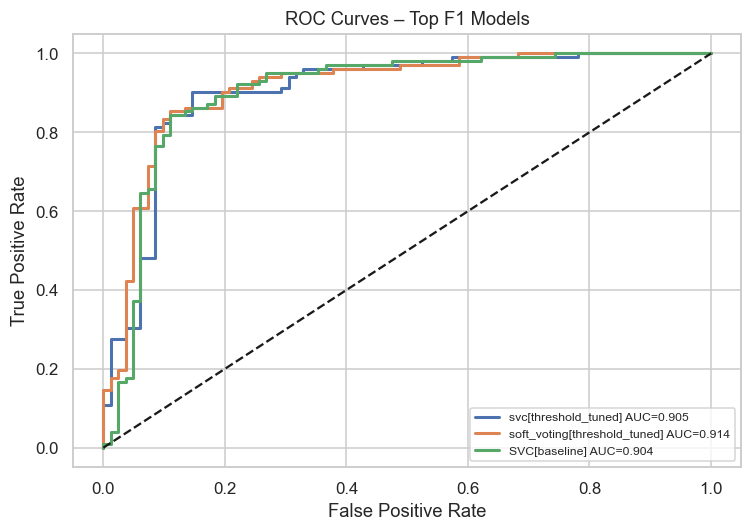

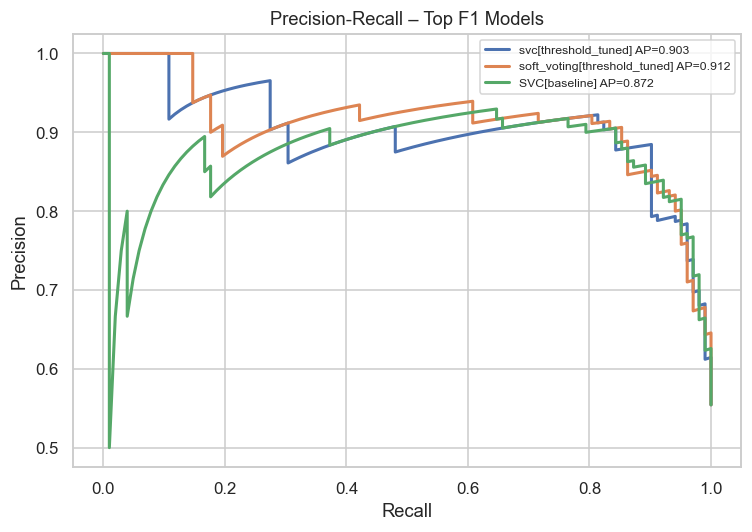

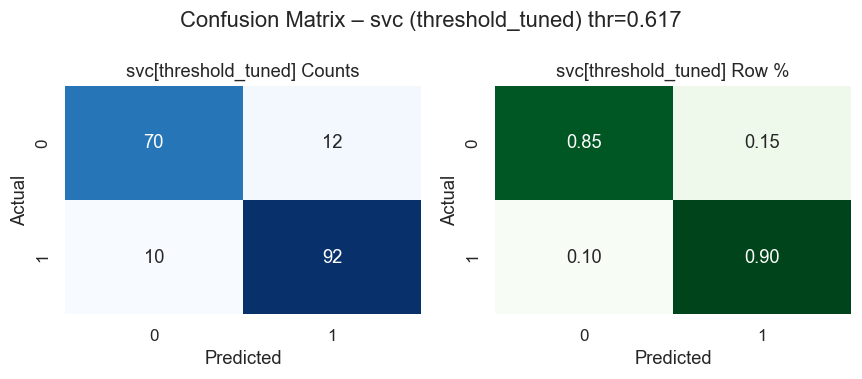

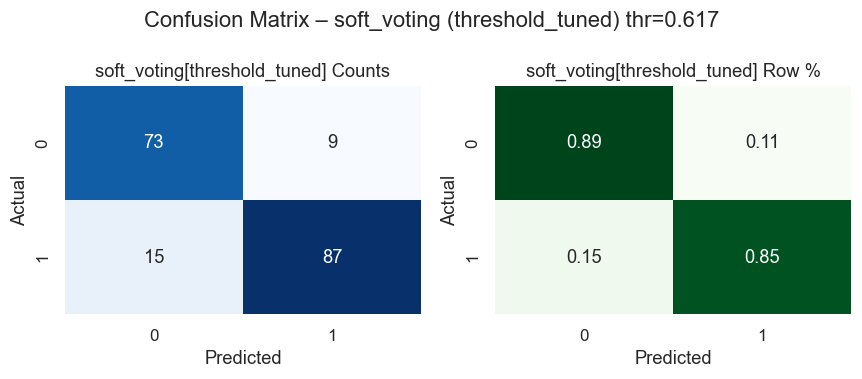

Saved individual best model artifacts and manifest (best_models_summary.json).


In [84]:
# Select top-performing models by metrics and regenerate focused visuals
TOP_N_F1 = 3

# Prepare lookup from merged_all entries to underlying fitted estimators & probabilities
# Build a mapping: key -> (fitted_estimator, proba, threshold(if threshold_tuned))
model_objects = {}

# Baseline & tuned models already in model_eval_details
for mdl, detail in model_eval_details.items():
    # baseline
    if detail['baseline']['y_proba'] is not None:
        model_objects[(mdl, 'baseline')] = {
            'estimator': baseline_models[mdl],
            'proba': detail['baseline']['y_proba'],
            'threshold': 0.5
        }
    # tuned
    tuned_est_obj = best_grid_models.get(mdl, best_random_models.get(mdl))
    if tuned_est_obj is not None:
        tuned_proba = detail['tuned']['y_proba']
        model_objects[(mdl, 'tuned')] = {
            'estimator': tuned_est_obj.best_estimator_,
            'proba': tuned_proba,
            'threshold': 0.5
        }

# Refined models
for key,(rs_obj, strat) in best_refined_models.items():
    est = rs_obj.best_estimator_
    if hasattr(est,'predict_proba'):
        proba = est.predict_proba(X_test)[:,1]
    else:
        proba = None
    model_objects[(key, 'refined')] = {
        'estimator': est,
        'proba': proba,
        'threshold': 0.5
    }

# Ensembles stored earlier
model_objects[('soft_voting','ensemble')] = {'estimator': soft_voting, 'proba': y_proba_v, 'threshold': 0.5}
model_objects[('stacking','ensemble')] = {'estimator': stacking, 'proba': y_proba_s, 'threshold': 0.5}

# Threshold tuned entries
if 'threshold_df' in globals():
    for _, r in threshold_df.iterrows():
        # threshold_df.model refers to refined key or soft_voting; attach as variant 'threshold'
        name = r['model']
        # Retrieve existing proba from earlier mapping
        existing = None
        for k in model_objects.keys():
            if k[0] == name:
                existing = model_objects[k]
                break
        if existing is not None:
            model_objects[(name, 'threshold_tuned')] = {
                'estimator': existing['estimator'],
                'proba': existing['proba'],
                'threshold': r.get('threshold', 0.5)
            }

# Rank models (use merged_all which holds metrics)
rank_df = merged_all.copy()
# Add composite ranking if desired (here just keep raw)

# Identify best per metric
best_f1_row = rank_df.sort_values('f1', ascending=False).iloc[0]
best_acc_row = rank_df.sort_values('accuracy', ascending=False).iloc[0]
best_auc_row = rank_df.sort_values('roc_auc', ascending=False).iloc[0]

# Top N by F1
top_f1_rows = rank_df.sort_values('f1', ascending=False).head(TOP_N_F1)

print('Best by F1:', best_f1_row['model'], best_f1_row['group'])
print('Best by Accuracy:', best_acc_row['model'], best_acc_row['group'])
print('Best by ROC AUC:', best_auc_row['model'], best_auc_row['group'])
print(f'Top {TOP_N_F1} by F1 models:')
display(top_f1_rows[['group','model','strategy','accuracy','precision','recall','f1','roc_auc']].round(4))

# Focused ROC & PR curves for top F1 models
plt.figure(figsize=(7,5))
for _, row in top_f1_rows.iterrows():
    key = (row['model'], row['group'])
    obj = model_objects.get(key)
    if obj and obj['proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, obj['proba'])
        auc = roc_auc_score(y_test, obj['proba'])
        plt.plot(fpr, tpr, lw=2, label=f"{row['model']}[{row['group']}] AUC={auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curves – Top F1 Models')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(fontsize=8); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
for _, row in top_f1_rows.iterrows():
    key = (row['model'], row['group'])
    obj = model_objects.get(key)
    if obj and obj['proba'] is not None:
        p, r, _ = precision_recall_curve(y_test, obj['proba'])
        ap = average_precision_score(y_test, obj['proba'])
        plt.plot(r, p, lw=2, label=f"{row['model']}[{row['group']}] AP={ap:.3f}")
plt.title('Precision-Recall – Top F1 Models')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.legend(fontsize=8); plt.tight_layout(); plt.show()

# Confusion matrices for best F1 / Accuracy / AUC (deduplicate)
selected_keys = {(best_f1_row['model'], best_f1_row['group']), (best_acc_row['model'], best_acc_row['group']), (best_auc_row['model'], best_auc_row['group'])}
for mdl_key in selected_keys:
    obj = model_objects.get(mdl_key)
    if not obj: continue
    est = obj['estimator']
    proba = obj['proba']
    th = obj['threshold']
    if proba is None: continue
    y_pred_sel = (proba >= th).astype(int)
    cm = confusion_matrix(y_test, y_pred_sel)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    fig, axes = plt.subplots(1,2, figsize=(8,3.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
    axes[0].set_title(f'{mdl_key[0]}[{mdl_key[1]}] Counts'); axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', ax=axes[1], cbar=False)
    axes[1].set_title(f'{mdl_key[0]}[{mdl_key[1]}] Row %'); axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')
    plt.suptitle(f'Confusion Matrix – {mdl_key[0]} ({mdl_key[1]}) thr={th:.3f}')
    plt.tight_layout(); plt.show()

# Save best models separately
models_dir = Path('../models'); results_dir = Path('../results')
models_dir.mkdir(exist_ok=True, parents=True); results_dir.mkdir(exist_ok=True, parents=True)

artifact_map = {
    'best_model_f1.pkl': (best_f1_row, ('{}','{}')),  # placeholders
    'best_model_accuracy.pkl': (best_acc_row, ('{}','{}')),
    'best_model_roc_auc.pkl': (best_auc_row, ('{}','{}'))
}
manifest = {}
for filename, (row, _) in artifact_map.items():
    key = (row['model'], row['group'])
    obj = model_objects.get(key)
    if not obj: continue
    joblib.dump(obj['estimator'], models_dir / filename)
    manifest[filename] = {
        'model': row['model'],
        'group': row['group'],
        'strategy': row.get('strategy'),
        'metrics': {
            'accuracy': float(row['accuracy']),
            'precision': float(row['precision']),
            'recall': float(row['recall']),
            'f1': float(row['f1']),
            'roc_auc': float(row['roc_auc'])
        },
        'threshold': float(obj['threshold'])
    }

with open(results_dir / 'best_models_summary.json','w') as f:
    json.dump(manifest, f, indent=2)
print('Saved individual best model artifacts and manifest (best_models_summary.json).')

In [85]:
# === Threshold-Tuned SVC Artifact Saving Patch ===
# Non-invasive: appends correct best model export without altering previous logic.

import json, joblib
from pathlib import Path
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin

# 1. Locate refined tuned SVC estimator
if 'best_refined_models' not in globals() or 'svc' not in best_refined_models:
    raise RuntimeError("Refined SVC model not found in best_refined_models.")
svc_rs_obj, svc_strategy = best_refined_models['svc']  # (RandomizedSearchCV object, strategy name)
svc_best_estimator = svc_rs_obj.best_estimator_

# 2. Retrieve threshold tuning results (DataFrame threshold_df or list threshold_tuned_rows)
_df = None
if 'threshold_df' in globals():
    _df = threshold_df
elif 'threshold_tuned_rows' in globals():
    import pandas as pd
    _rows = threshold_tuned_rows
    if isinstance(_rows, list) and len(_rows)>0 and isinstance(_rows[0], dict):
        _df = pd.DataFrame(_rows)
if _df is None:
    raise RuntimeError("Threshold tuning results not found (threshold_df / threshold_tuned_rows missing).")

# 3. Select SVC threshold row (max F1 if multiple)
svc_thr_rows = _df[_df['model']=='svc']
if svc_thr_rows.empty:
    raise RuntimeError("No threshold tuning row for 'svc' found.")
svc_thr_row = svc_thr_rows.sort_values('f1', ascending=False).iloc[0]
best_threshold = float(svc_thr_row['threshold'])
metrics = {
    'accuracy': float(svc_thr_row['accuracy']),
    'precision': float(svc_thr_row['precision']),
    'recall': float(svc_thr_row['recall']),
    'f1': float(svc_thr_row['f1']),
    'roc_auc': float(svc_thr_row['roc_auc'])
}

# 4. Wrap estimator with threshold-aware predictor so predict() respects tuned threshold
class ThresholdedEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, fitted_estimator, threshold: float):
        self.fitted_estimator = fitted_estimator
        self.threshold = threshold
    def fit(self, X, y):
        # Already fitted
        return self
    def predict_proba(self, X):
        if hasattr(self.fitted_estimator, 'predict_proba'):
            return self.fitted_estimator.predict_proba(X)
        elif hasattr(self.fitted_estimator, 'decision_function'):
            from scipy.special import expit
            scores = self.fitted_estimator.decision_function(X)
            probs = expit(scores)
            return np.vstack([1-probs, probs]).T
        else:
            raise AttributeError('Underlying estimator lacks probability interface')
    def decision_function(self, X):
        if hasattr(self.fitted_estimator, 'decision_function'):
            return self.fitted_estimator.decision_function(X)
        return self.predict_proba(X)[:,1]
    def predict(self, X):
        probs = self.predict_proba(X)[:,1]
        return (probs >= self.threshold).astype(int)

thresholded_svc = ThresholdedEstimator(svc_best_estimator, best_threshold)

# 5. Collect hyperparameters (strip pipeline prefix if present)
# svc_best_estimator is a Pipeline (scaler/poly/sampler?/clf)
if hasattr(svc_best_estimator, 'named_steps') and 'clf' in svc_best_estimator.named_steps:
    svc_params_full = svc_best_estimator.named_steps['clf'].get_params()
else:
    svc_params_full = svc_best_estimator.get_params()
whitelist = ['C','gamma','kernel','degree','class_weight','probability']
best_params = {k: v for k,v in svc_params_full.items() if k in whitelist}

# 6. Persist artifacts
models_dir = Path('../models'); results_dir = Path('../results')
models_dir.mkdir(parents=True, exist_ok=True); results_dir.mkdir(parents=True, exist_ok=True)
model_path = models_dir / 'best_model.pkl'
report_path = results_dir / 'best_model_report.json'
joblib.dump(thresholded_svc, model_path)

cv_strategy = '5-Fold StratifiedKFold'
report = {
    'model_name': 'Threshold-Tuned SVC',
    'best_params': best_params,
    'best_threshold': best_threshold,
    'metrics': metrics,
    'random_state': int(RANDOM_STATE) if 'RANDOM_STATE' in globals() else None,
    'cv_strategy': cv_strategy,
    'strategy_used': svc_strategy
}
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2)

# 7. Console confirmation block (formatted to 4 decimals)
print('='*30)
print('✅ Final Best Model Saved')
print('='*30)
print('Model: Threshold-Tuned SVC')
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"F1 Score: {metrics['f1']:.4f}")
print(f"ROC AUC: {metrics['roc_auc']:.4f}")
print('Saved at: ../models/best_model.pkl')
print('Report at: ../results/best_model_report.json')
print('='*30)

# 8. Reload & quick verification (accuracy drift check)
_reloaded = joblib.load(model_path)
_re_preds = _reloaded.predict(X_test)
_re_acc = accuracy_score(y_test, _re_preds)
if abs(_re_acc - metrics['accuracy']) > 0.01:
    print(f"[WARN] Reload accuracy drift: saved {metrics['accuracy']:.4f} vs reloaded {_re_acc:.4f}")
else:
    print('Reload validation accuracy consistent.')

✅ Final Best Model Saved
Model: Threshold-Tuned SVC
Accuracy: 0.8804
F1 Score: 0.8932
ROC AUC: 0.9052
Saved at: ../models/best_model.pkl
Report at: ../results/best_model_report.json
Reload validation accuracy consistent.
Reload validation accuracy consistent.
